<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/cnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D CNN for Time Series
In this notebook we use a 1D CNN to smooth a time series, that is to predict the target variable from the inputs extracted from a sequence by sliding the kernel function over it. We can use the output of the CNN as input to a LSTM.

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import keras
from keras import layers
print('NumPy version: %s'%np.__version__)
print('Pandas version: %s'%pd.__version__)
print('Matplotlib version: %s'%mpl.__version__)
print('TensorFlow version: %s'%tf.__version__)
print('Keras version: %s'%keras.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.10.0
TensorFlow version: 2.18.0
Keras version: 3.8.0


## Dataset and data window
We download the traffic datasets and define the data structure to build the batches of tensors for training, validation, and test.

In [2]:
def download_data(url):
  r = requests.get(url)
  data_path = url.rsplit('/')[-1]
  with open(data_path, 'wb') as f:
    f.write(r.content)
  return data_path

In [3]:
train_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/train.csv'
val_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/val.csv'
test_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/test.csv'
train_data = download_data(train_url)
val_data = download_data(val_url)
test_data = download_data(test_url)
train_df = pd.read_csv(train_data, index_col=0)
val_df = pd.read_csv(val_data, index_col=0)
test_df = pd.read_csv(test_data, index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [13]:
train_df.columns

Index(['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos'], dtype='object')

In [4]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        '''
        This function separates inputs and labels from the features.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        The function plots the model's predictions for three data windows
        '''
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        '''
        This function is based on a Keras function to create batches of data by sliding windows of inputs and lables from the train, validation, and test sets.
        The slide is set with the sequence_stride argument and it is set to 1. The data windows are shuffled but the order within each window is preserved.
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

We use the mean square error as loss function, and the mean absolute error as the performance metric.

In [5]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  metrics=[keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

## 1D CNN model single-step forecast
We use a 1D kernel of size 3 for the CNN in order to smooth the time series. The CNN model is trained to learn how to map the input features in a sequence to a target values, that is the traffic volume. The size of the output is given by

$$o = i - k + 1$$

where $o$ is the output, $i$ the input, and $k$ the kernel size.

We create a convolutional data window to train our CNN model and another data window for visualization purposes.

In [6]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

The input are sequences of 26 elements of 5 variables each.

In [24]:
conv_window.column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

the output is a sequence of 26 elements of the target variable, traffic volume shifted by one

In [25]:
conv_window.label_columns_indices

{'traffic_volume': 0}

We build a sequential model with a [1D convolutional layer](https://keras.io/api/layers/convolution_layers/convolution1d/), and two fully connected layers.

In [7]:
cnn_model = keras.Sequential([
    layers.Conv1D(filters=32,
             kernel_size=(KERNEL_WIDTH,),
             activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1)
])

In [8]:
history = compile_and_fit(cnn_model, conv_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0694 - mean_absolute_error: 0.1812 - val_loss: 0.0082 - val_mean_absolute_error: 0.0656
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0608 - val_loss: 0.0050 - val_mean_absolute_error: 0.0520
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0512 - val_loss: 0.0039 - val_mean_absolute_error: 0.0461
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0466 - val_loss: 0.0034 - val_mean_absolute_error: 0.0433
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0038 - mean_absolute_error: 0.0447 - val_loss: 0.0028 - val_mean_absolute_error: 0.0392
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0416 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - mean_absolute_error: 0.0405 - v

In [28]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 32)               │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,805 (18.77 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,204 (12.52 KB)

In [9]:
val_performance = {}
performance = {}
val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0318


We plot the single-step predictions of the CNN model for the traffic volume

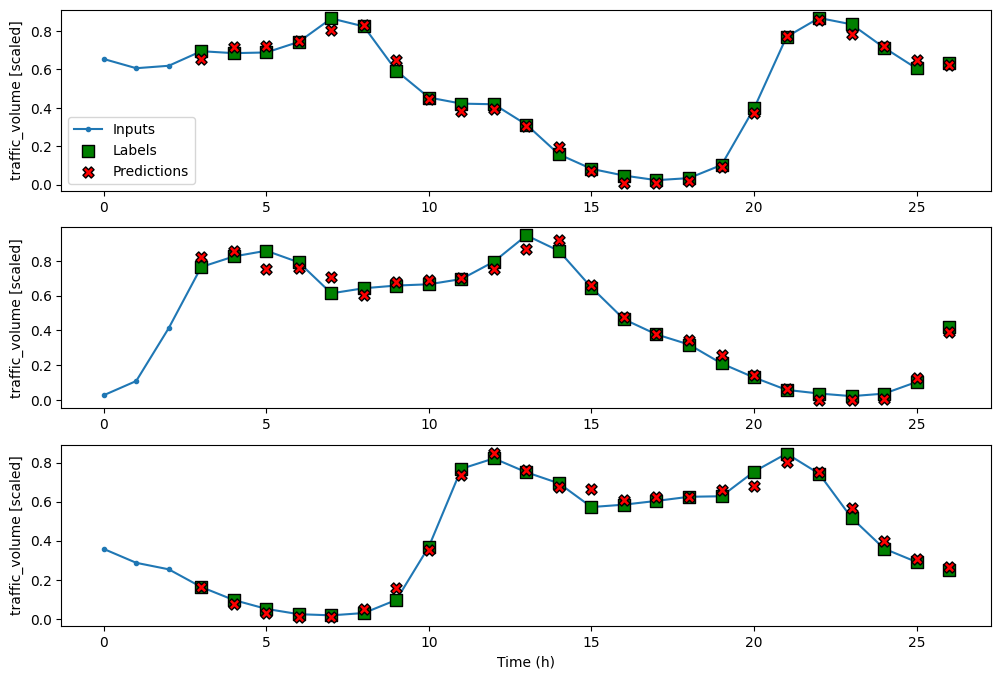

In [27]:
wide_conv_window.plot(cnn_model)

## 1D CNN + LSTM model single-step forecast
We combine a 1D CNN layer and an LSTM layer to test whether using a 1D CNN before a LSTM can improve the result of the LSTM alone.

In [29]:
cnn_lstm_model = keras.Sequential([
    layers.Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    layers.LSTM(32, return_sequences=True),
    # LSTM(32, return_sequences=True),
    layers.Dense(1)
])

In [30]:
history = compile_and_fit(cnn_lstm_model, conv_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0644 - mean_absolute_error: 0.1755 - val_loss: 0.0075 - val_mean_absolute_error: 0.0624
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0615 - val_loss: 0.0055 - val_mean_absolute_error: 0.0574
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0054 - mean_absolute_error: 0.0539 - val_loss: 0.0040 - val_mean_absolute_error: 0.0473
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0504 - val_loss: 0.0035 - val_mean_absolute_error: 0.0450
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - mean_absolute_error: 0.0470 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0438 - val_loss: 0.0037 - val_mean_absolute_error: 0.0480
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0424 - v

In [32]:
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 1, 32)               │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,597 (103.90 KB)

 Trainable params: 8,865 (34.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,732 (69.27 KB)

In [31]:
val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0336


We compare the performances of all the models we have built so far.

In [33]:
mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

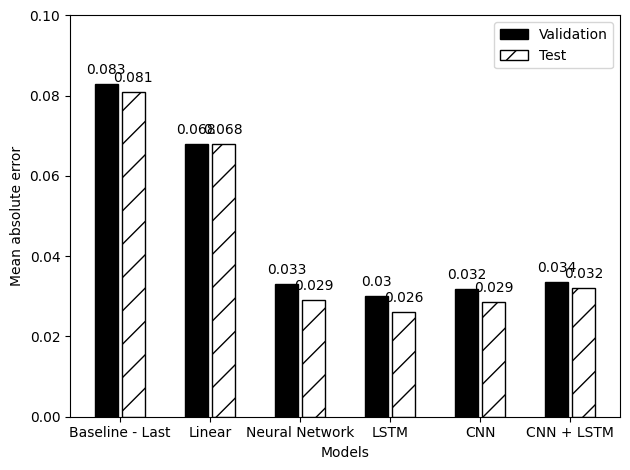

In [35]:
x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Neural Network', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

As we can see using a 1D CNN before a LSTM layer does not improve the result and the LSTM model alone is still the best model so far.

## 1D CNN model multi-step forecast


In [37]:
multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [36]:
ms_cnn_model = keras.Sequential([
  layers.Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
  layers.Dense(units=32, activation='relu'),
  layers.Dense(1, kernel_initializer=tf.initializers.zeros),
])